# 🧠 BRISC Binary Classification: Model Evaluation
This notebook evaluates multiple pre-trained ResNet-18 models on the BRISC 2025 classification dataset. 

## 1. Setup and Environment
Mount Google Drive to access saved model weights and fetch the dataset from Kaggle.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import kagglehub

# Download latest version
brics_test_path = kagglehub.dataset_download("briscdataset/brisc2025")

print("Path to dataset files:", brics_test_path)

100%|██████████| 250M/250M [00:01<00:00, 148MB/s]  

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/briscdataset/brisc2025/versions/6


In [3]:
!find {brics_test_path} -maxdepth 3

/root/.cache/kagglehub/datasets/briscdataset/brisc2025/versions/6
/root/.cache/kagglehub/datasets/briscdataset/brisc2025/versions/6/brisc2025
/root/.cache/kagglehub/datasets/briscdataset/brisc2025/versions/6/brisc2025/classification_task
/root/.cache/kagglehub/datasets/briscdataset/brisc2025/versions/6/brisc2025/classification_task/test
/root/.cache/kagglehub/datasets/briscdataset/brisc2025/versions/6/brisc2025/classification_task/train
/root/.cache/kagglehub/datasets/briscdataset/brisc2025/versions/6/brisc2025/README.md
/root/.cache/kagglehub/datasets/briscdataset/brisc2025/versions/6/brisc2025/manifest.csv.sha256
/root/.cache/kagglehub/datasets/briscdataset/brisc2025/versions/6/brisc2025/manifest.csv
/root/.cache/kagglehub/datasets/briscdataset/brisc2025/versions/6/brisc2025/manifest.json.sha256
/root/.cache/kagglehub/datasets/briscdataset/brisc2025/versions/6/brisc2025/segmentation_task
/root/.cache/kagglehub/datasets/briscdataset/brisc2025/versions/6/brisc2025/segmentation_task/tes

In [4]:
import kagglehub

# Download latest version
fig_share_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", fig_share_path)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [5]:
!find {fig_share_path} -maxdepth 2

/kaggle/input/brain-tumor-mri-dataset
/kaggle/input/brain-tumor-mri-dataset/Training
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary
/kaggle/input/brain-tumor-mri-dataset/Training/notumor
/kaggle/input/brain-tumor-mri-dataset/Training/meningioma
/kaggle/input/brain-tumor-mri-dataset/Training/glioma
/kaggle/input/brain-tumor-mri-dataset/Testing
/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary
/kaggle/input/brain-tumor-mri-dataset/Testing/notumor
/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma
/kaggle/input/brain-tumor-mri-dataset/Testing/glioma


In [6]:
BRICS_TEST_DIR = brics_test_path +'/brisc2025/classification_task/test/'
FIG_SHARE_TEST_DIR = fig_share_path + '/Testing/'
BATCH_SIZE = 64
EPOCHS = 15
LEARNING_RATE = 0.001
input_size = 224 
reshape_size =256

## 2. Imports and Configuration
Load all necessary libraries and set the global hyperparameters and directory paths.

In [7]:
%pip install grad-cam shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.5 MB/s eta 0:00:00ta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44285 sha256=667baffbe5364e27cf55df8f8ac4ec06e0ad443cd8d73100adedf9209c2f720f
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [8]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd


from torch.utils.data import DataLoader

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

## 3. Data Loading and Preprocessing
Define the image transformations and initialize the test DataLoader.

In [9]:
# Define how to process the images


transform = transforms.Compose([
    transforms.Resize((reshape_size, reshape_size)),
    transforms.RandomHorizontalFlip(p=0.5), # Flips 50% of images like a mirror
    transforms.RandomRotation(degrees=15 ),
    transforms.CenterCrop((input_size, input_size)),  # Tilts the brain up to 15 degrees
    
    transforms.ToTensor(),
])
binary_transform = lambda target: 0 if target == 2 else 1

brics_test_dataset = datasets.ImageFolder(
    root=BRICS_TEST_DIR,
    transform=transform,
    target_transform=binary_transform
)

figshare_test_dataset = datasets.ImageFolder(
    root=FIG_SHARE_TEST_DIR,
    transform=transform,
    target_transform=binary_transform
)

# shuffle=False is important here so we can match predictions to the right labels
brics_test_loader = DataLoader(brics_test_dataset, batch_size=32, shuffle=False)

figshare_test_loader = DataLoader(figshare_test_dataset, batch_size=32, shuffle=False)

test_loaders = {
    "BRISC": brics_test_loader, 
    "Figshare": figshare_test_loader
}

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 4. Helper Functions
Define reusable functions for loading models and evaluating their performance.

In [11]:
def load_resnet_model(weight_path, device):
    """Builds the ResNet-18 skeleton and loads custom weights."""
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 1)
    model.load_state_dict(torch.load(weight_path, map_location=device))
    return model.to(device)


def evaluate_model_multidataset(model, test_loaders, device, threshold=0.3, model_name="Model"):
    """
    Evaluates a PyTorch binary classification model on multiple datasets 
    and plots Confusion Matrices side-by-side in a 1x2 grid.
    
    Args:
        model: The PyTorch model to evaluate.
        test_loaders: A dictionary of DataLoaders {'Dataset1': loader1, 'Dataset2': loader2}.
        device: The device to run on (e.g., 'cuda' or 'cpu').
        threshold: The probability threshold for positive classification (default: 0.3).
        model_name: String name of the model for titles and print statements.
    """
    print(f"\nEvaluating {model_name} on multiple datasets...")
    model.eval() 
    
    # Set up the 1x2 subplot grid (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'{model_name} - Confusion Matrices', fontsize=16, y=1.05)
    
    # Store metrics to return later if needed
    results = {}

    with torch.no_grad(): 
        # Loop through each dataset
        for idx, (dataset_name, loader) in enumerate(test_loaders.items()):
            print(f"\nProcessing {dataset_name} Dataset...")
            all_preds, all_labels, all_probs = [], [], []
            
            for images, labels in loader:
                images = images.to(device)
                labels = labels.to(device).float()

                outputs = model(images).squeeze()
                
                # Safety check for batch size of 1
                if outputs.dim() == 0:
                    outputs = outputs.unsqueeze(0)
                    
                probs = torch.sigmoid(outputs)    
                preds = (probs >= threshold).float()    

                all_probs.extend(probs.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            # Calculate Core Metrics
            accuracy = accuracy_score(all_labels, all_preds)
            sensitivity = recall_score(all_labels, all_preds)
            f1 = f1_score(all_labels, all_preds)
            auc = roc_auc_score(all_labels, all_probs)
            
            tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
            specificity = tn / (tn + fp)

            print(f"--- {dataset_name} Results ---")
            print(f"Accuracy:    {accuracy * 100:.2f}% | Sensitivity: {sensitivity * 100:.2f}%")
            print(f"Specificity: {specificity * 100:.2f}% | F1-Score:    {f1:.4f} | AUC: {auc:.4f}")

            results[dataset_name] = {
                "Accuracy": accuracy, 
                "Sensitivity": sensitivity, 
                "Specificity": specificity, 
                "F1": f1, 
                "AUC": auc
            }

            # --- Plot: Confusion Matrix ---
            cm = confusion_matrix(all_labels, all_preds)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['No Tumor', 'Tumor'],
                        yticklabels=['No Tumor', 'Tumor'],
                        annot_kws={"size": 14}, 
                        ax=axes[idx]) # Maps to axes[0] then axes[1]
            
            axes[idx].set_ylabel('Actual Diagnosis', fontsize=12)
            axes[idx].set_xlabel('Model Prediction', fontsize=12)
            axes[idx].set_title(f'{dataset_name}', fontsize=14, pad=10)

    plt.tight_layout() 
    plt.show() 
    
    return results

## 5. Model Inference & Comparison
Load each saved model and pass it through the evaluation pipeline.

In [12]:
!find /content/drive/MyDrive/my_models

/content/drive/MyDrive/my_models
/content/drive/MyDrive/my_models/binary_brain_tumor_detector.h5
/content/drive/MyDrive/my_models/binary_brain_tumor_detector.keras
/content/drive/MyDrive/my_models/my_brisc_binary_model.pth
/content/drive/MyDrive/my_models/Copy of my_brisc_binary_model_312.pth
/content/drive/MyDrive/my_models/Copy of my_brisc_binary_model.pth


In [13]:

# 1. Build the Model "Skeleton" (using weights=None so it doesn't download ImageNet weights)
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 1)

# 2. Load Your Trained Weights into the Skeleton
model_path = '/content/drive/MyDrive/my_models/my_brisc_binary_model.pth' # Make sure this path is correct
model.load_state_dict(torch.load(model_path, map_location=device))

# 3. Move the loaded model to the correct device (GPU or CPU)
model = model.to(device)

print("Model successfully loaded and ready for inference!")

Model successfully loaded and ready for inference!


In [14]:
THRESHOLD = 0.5 # Your original threshold for classifying Tumor vs No Tumor


Evaluating ResNet-18 V1 on multiple datasets...

Processing BRISC Dataset...
--- BRISC Results ---
Accuracy:    99.30% | Sensitivity: 99.65%
Specificity: 97.14% | F1-Score:    0.9959 | AUC: 0.9991

Processing Figshare Dataset...
--- Figshare Results ---
Accuracy:    91.19% | Sensitivity: 96.92%
Specificity: 74.00% | F1-Score:    0.9428 | AUC: 0.9748


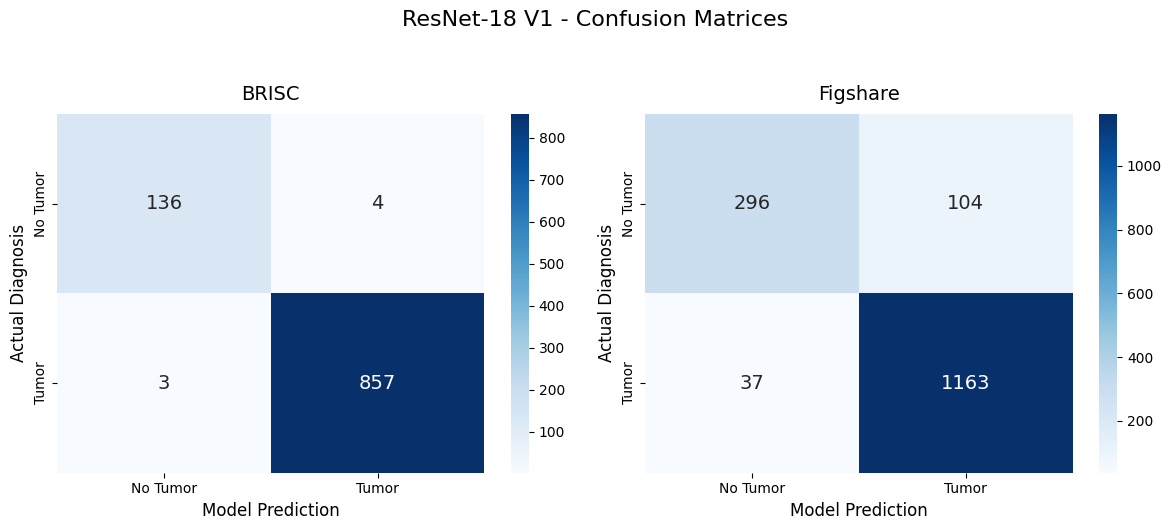

In [15]:
# --- Evaluate Model V1 ---
path_v1 = '/content/drive/MyDrive/my_models/my_brisc_binary_model.pth'
model_v1 = load_resnet_model(path_v1, device)

metrics_v1 = evaluate_model_multidataset(model_v1, test_loaders, device, THRESHOLD, "ResNet-18 V1")


Evaluating ResNet-18 V2 on multiple datasets...

Processing BRISC Dataset...
--- BRISC Results ---
Accuracy:    98.70% | Sensitivity: 99.53%
Specificity: 93.57% | F1-Score:    0.9925 | AUC: 0.9992

Processing Figshare Dataset...
--- Figshare Results ---
Accuracy:    86.69% | Sensitivity: 99.08%
Specificity: 49.50% | F1-Score:    0.9178 | AUC: 0.9691


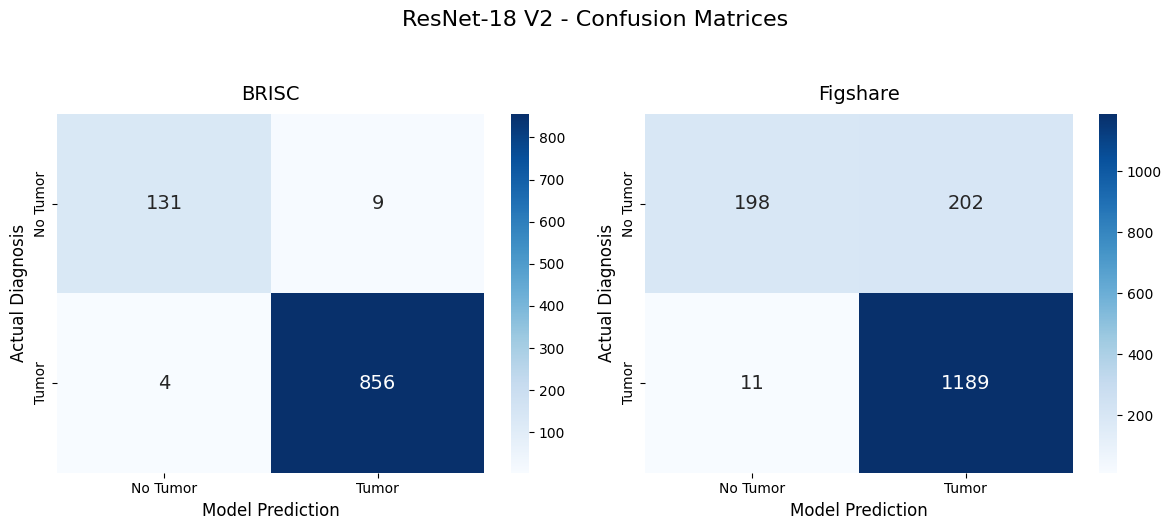

In [16]:
# --- Evaluate Model V2 ---
path_v2 = '/content/drive/MyDrive/my_models/Copy of my_brisc_binary_model_312.pth'
model_v2 = load_resnet_model(path_v2, device)

metrics_v2 = evaluate_model_multidataset(model_v2, test_loaders, device, THRESHOLD, "ResNet-18 V2")


Evaluating ResNet-18 V3 on multiple datasets...

Processing BRISC Dataset...
--- BRISC Results ---
Accuracy:    96.20% | Sensitivity: 100.00%
Specificity: 72.86% | F1-Score:    0.9784 | AUC: 0.9997

Processing Figshare Dataset...
--- Figshare Results ---
Accuracy:    84.25% | Sensitivity: 99.75%
Specificity: 37.75% | F1-Score:    0.9048 | AUC: 0.9449


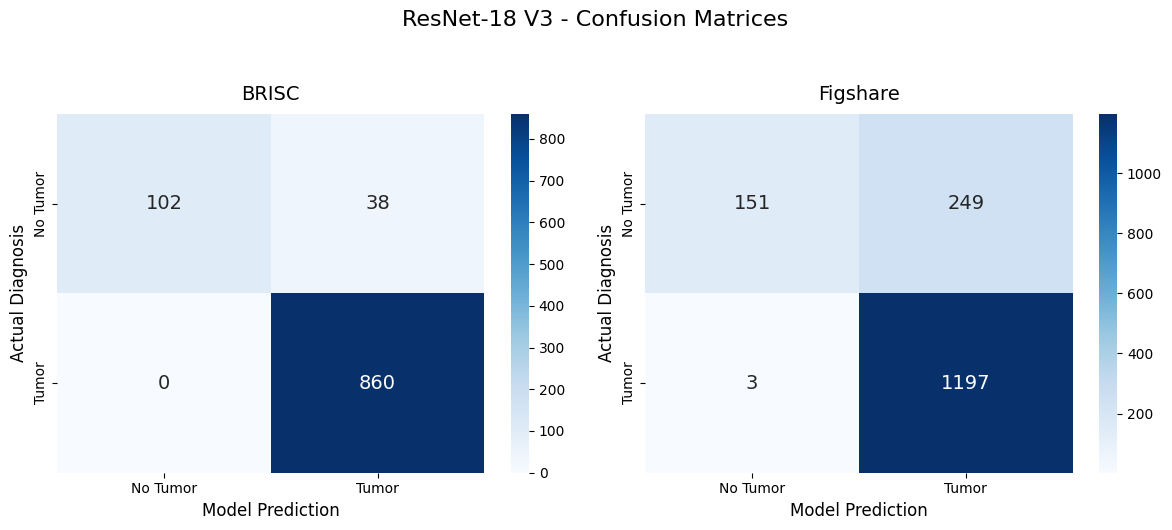

In [17]:
# --- Evaluate Model V3 ---
path_v3 = '/content/drive/MyDrive/my_models/Copy of my_brisc_binary_model.pth'
model_v3 = load_resnet_model(path_v3, device)

metrics_v3 = evaluate_model_multidataset(model_v3, test_loaders, device, THRESHOLD, "ResNet-18 V3")

In [18]:
import pandas as pd

# Assuming multi_metrics_v1, multi_metrics_v2, and multi_metrics_v3 are the 
# dictionaries returned by your new `evaluate_model_multidataset` function.

# 1. Group the results from all models
model_results = {
    "ResNet-18 V1": metrics_v1,
    "ResNet-18 V2": metrics_v2,
    "ResNet-18 V3": metrics_v3
}

# 2. Flatten the nested dictionaries so Pandas can create a MultiIndex (Model -> Dataset)
all_metrics = {}
for model_name, dataset_dict in model_results.items():
    for dataset_name, metrics in dataset_dict.items():
        # Create a tuple key like ("ResNet-18 V1", "BRISC")
        all_metrics[(model_name, dataset_name)] = metrics

# 3. Convert to a pandas DataFrame
df_comparison = pd.DataFrame(all_metrics)

# 4. Optional: Format the numbers so they are easier to read
def format_metrics(x, metric_name):
    if metric_name in ['Accuracy', 'Sensitivity', 'Specificity']:
        return f"{x * 100:.2f}%"
    return f"{x:.4f}"

for row in df_comparison.index:
    df_comparison.loc[row] = df_comparison.loc[row].apply(lambda x: format_metrics(x, row))

# 5. Display the final multi-dataset table
print("\n=== Final Multi-Dataset Model Comparison ===")
display(df_comparison)


=== Final Multi-Dataset Model Comparison ===


/tmp/ipython-input-3034381107.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99.30%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comparison.loc[row] = df_comparison.loc[row].apply(lambda x: format_metrics(x, row))
/tmp/ipython-input-3034381107.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '91.19%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comparison.loc[row] = df_comparison.loc[row].apply(lambda x: format_metrics(x, row))
/tmp/ipython-input-3034381107.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '98.70%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comparison.loc[row] = df_c

ResNet-18 V1          ResNet-18 V2          ResNet-18 V3         
                   BRISC Figshare        BRISC Figshare        BRISC Figshare
Accuracy          99.30%   91.19%       98.70%   86.69%       96.20%   84.25%
Sensitivity       99.65%   96.92%       99.53%   99.08%      100.00%   99.75%
Specificity       97.14%   74.00%       93.57%   49.50%       72.86%   37.75%
F1                0.9959   0.9428       0.9925   0.9178       0.9784   0.9048
AUC               0.9991   0.9748       0.9992   0.9691       0.9997   0.9449

# 6.1 Grad-CAM Visualization

In [19]:

import shap

def visualize_gradcam(model, input_tensor, actual_label=None, target_layer=None):
    """
    Generates and plots a Grad-CAM heatmap for a given image tensor.
    
    Args:
        model: The trained PyTorch model.
        input_tensor: A single image tensor of shape (1, C, H, W).
        actual_label: (Optional) The true label of the image for the plot title.
        target_layer: (Optional) The convolutional layer to hook into. Defaults to ResNet layer4.
    """
    model.eval()
    
    # Default to ResNet's last conv layer if none is provided
    if target_layer is None:
        target_layer = [model.layer4[-1]]
    else:
        target_layer = [target_layer]
        
    # Initialize Grad-CAM
    cam = GradCAM(model=model, target_layers=target_layer)
    
    # Generate heatmap for the default predicted class
    targets = [ClassifierOutputTarget(0)] # Adjust if you have multi-class
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
    
    # Convert tensor to RGB image for visualization (H, W, C)
    # Assuming input is in [0, 1] range. If normalized with ImageNet stats, you'd need to denormalize first.
    rgb_img = input_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
    
    # Overlay heatmap
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_img)
    title = f"Original MRI" if actual_label is None else f"Original MRI (True Label: {actual_label})"
    plt.title(title)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title("Grad-CAM Focus Area")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [36]:
def visualize_shap(model, background_tensors, test_tensors):
    """
    Generates and plots SHAP pixel attribution maps.
    """
    model.eval()
    
    # 1. Initialize Explainer and get SHAP values
    explainer = shap.GradientExplainer(model, background_tensors)
    shap_values = explainer.shap_values(test_tensors)
    
    # 2. Format original test images -> Must be (Batch, Height, Width, Channels)
    test_numpy = test_tensors.cpu().detach().numpy()
    if test_numpy.ndim == 3:
        test_numpy = np.expand_dims(test_numpy, axis=0)
    if test_numpy.shape[1] in [1, 3]: # Transpose (B, C, H, W) to (B, H, W, C)
        test_numpy = np.transpose(test_numpy, (0, 2, 3, 1))
        
    # 3. Format SHAP values
    # Safely convert PyTorch tensors to NumPy arrays if necessary
    if torch.is_tensor(shap_values):
        shap_values = shap_values.cpu().detach().numpy()
    elif isinstance(shap_values, list) and torch.is_tensor(shap_values[0]):
        shap_values = [sv.cpu().detach().numpy() for sv in shap_values]
        
    # If SHAP returned a 5D array: (Classes, Batch, Channels, Height, Width)
    # We must split it into a list along the 0th axis (Classes)
    if isinstance(shap_values, np.ndarray) and shap_values.ndim == 5:
        shap_values = [shap_values[i] for i in range(shap_values.shape[0])]
        
    # Force it into a list if it's a single array
    if not isinstance(shap_values, list):
        shap_values = [shap_values]
        
    shap_numpy_list = []
    for sv in shap_values:
        if not isinstance(sv, np.ndarray):
            sv = np.array(sv)
            
        if sv.ndim == 3: # If single image (C, H, W), add batch dim
            sv = np.expand_dims(sv, axis=0)
            
        # Now we expect sv to be exactly 4D: (Batch, Channels, H, W)
        # We transpose it to match Matplotlib's (Batch, H, W, Channels)
        if sv.ndim == 4 and sv.shape[1] in [1, 3]: 
            sv = np.transpose(sv, (0, 2, 3, 1))
            
        shap_numpy_list.append(sv)
        
    # 4. Plot
    print("Generating SHAP plots (Red = pushes to Tumor, Blue = pushes to No Tumor)...")
    shap.image_plot(shap_numpy_list, test_numpy)

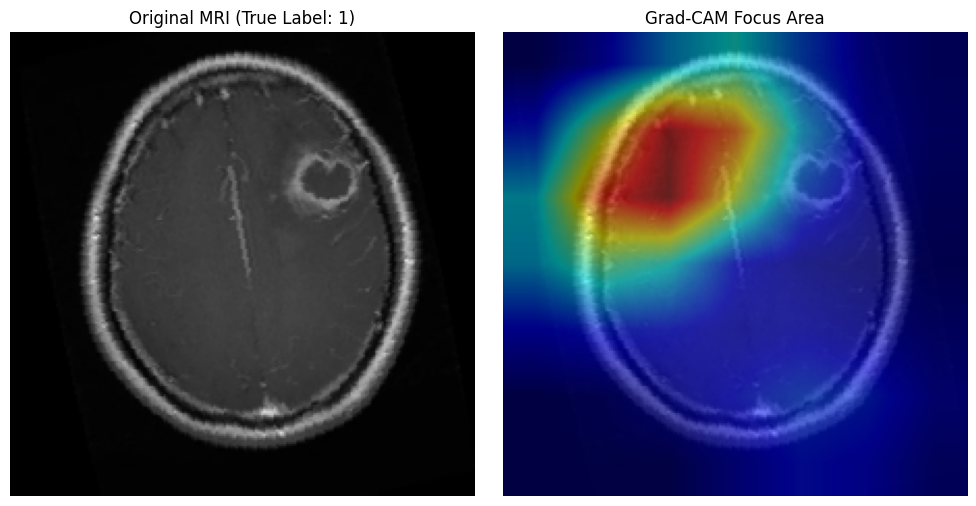

Generating SHAP plots (Red = pushes to Tumor, Blue = pushes to No Tumor)...


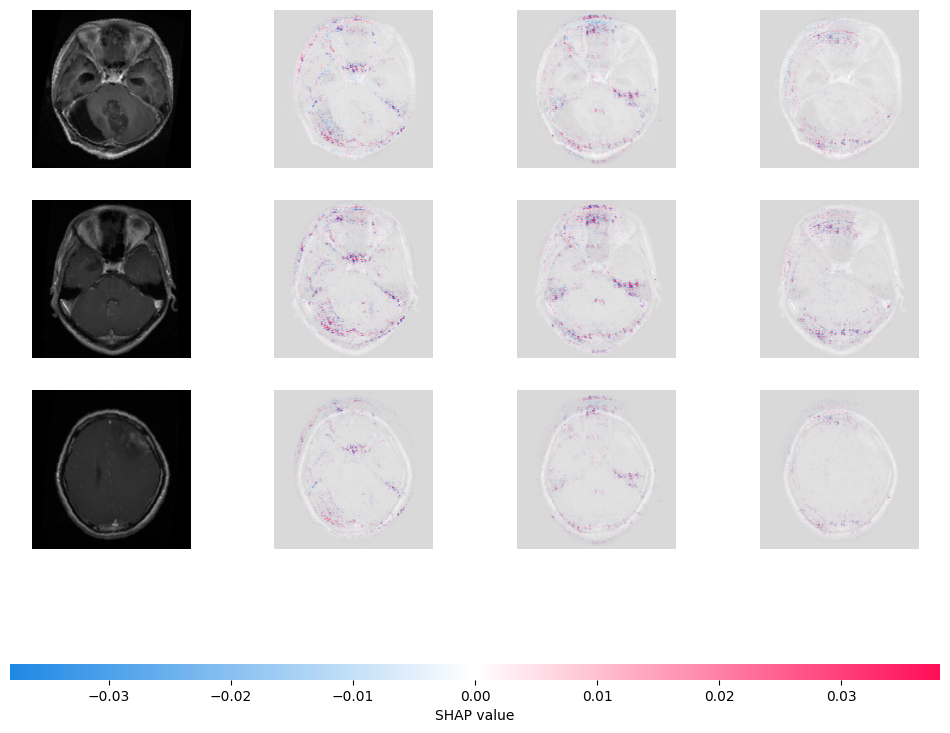

In [37]:
data_iter = iter(brics_test_loader)
images, labels = next(data_iter)
images = images.to(device) # Ensure they are on the right device (CPU or CUDA)

# --- 1. Run Grad-CAM ---
# Let's visualize the 5th image in the batch
single_image_tensor = images[20].unsqueeze(0) 
single_label = labels[20].item()

visualize_gradcam(
    model=model_v1, # Replace with your actual model variable 
    input_tensor=single_image_tensor, 
    actual_label=single_label
)

# --- 2. Run SHAP ---
# Use the whole batch (32 images) as the background
background = images

# Let's explain the first 3 images in the batch
images_to_explain = images[0:3]

visualize_shap(
    model=model_v1, # Replace with your actual model variable
    background_tensors=background,
    test_tensors=images_to_explain
)